## Set up notebook

In [2]:
%env PYTHONHASHSEED=0

#import libaries
import numpy as np
from numpy.random import seed
import random as python_random
import tensorflow as tf

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
tf.random.set_seed(1234)

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras import backend as K
from keras import models

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, roc_auc_score
import itertools
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score

env: PYTHONHASHSEED=0


In [3]:
#set up function for confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
#set up evaluation metric functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Image Preprocessing (rescale, resize, reshape)

In [11]:
#create directory to train, test, val data
test_folder = '../data_val/test'
train_folder = '../data_val/train'
val_folder = '../data_val/val'

In [12]:
#rescale and resize train, val, test data
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224,224), batch_size = 390) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224,224), batch_size = 247)

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(224,224), batch_size=3636)

Found 390 images belonging to 2 classes.
Found 247 images belonging to 2 classes.
Found 3636 images belonging to 2 classes.


In [13]:
#split data to images and labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [14]:
#reshape data
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

train_y = np.reshape(train_labels[:,0], (3636,1))
test_y = np.reshape(test_labels[:,0], (390,1))
val_y = np.reshape(val_labels[:,0], (247,1))

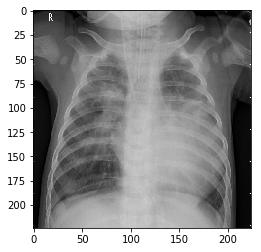

In [15]:
plt.imshow(train_images[123])

## Create model

In [19]:
# import DenseNet121 without bottom pieces
densenet_model = keras.applications.DenseNet121(include_top = False) 

In [20]:
densenet_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [24]:
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras import backend as K

In [26]:
# add the bottom pieces to densenet_model
# add a global spatial average pooling layer
x = densenet_model.output #.output is all of the layers 
x = GlobalAveragePooling2D()(x) #adding a layer to x (pretrained densenet121)
# add a fully-connected layer
x = Dense(10, activation='relu')(x) 
predictions = Dense(2, activation='softmax')(x) #note, last part must always be the number of category 

In [27]:
model = Model(inputs=densenet_model.input, outputs=predictions)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [32]:
for layer in densenet_model.layers:
    layer.trainable = False

In [33]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator()

In [34]:
from keras.utils import np_utils

In [35]:
# convert y_train to categorical 
y_train = np_utils.to_categorical(train_y, 2)

In [36]:
y_train.shape

(3636, 2)

In [37]:
y_val = np_utils.to_categorical(val_y, 2)

## Train model

In [40]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives()])
history = model.fit(x = train_images, y = y_train, batch_size= 64, epochs = 10, validation_data= (val_images, y_val), verbose = 1 )

Train on 3636 samples, validate on 247 samples
Epoch 1/10
3636/3636 [==============================] - 326s 90ms/sample - loss: 0.5651 - acc: 0.7041 - precision: 0.7041 - recall: 0.7041 - true_positives: 2560.0000 - true_negatives: 2560.0000 - val_loss: 0.9443 - val_acc: 0.4575 - val_precision: 0.4575 - val_recall: 0.4575 - val_true_positives: 113.0000 - val_true_negatives: 113.0000
Epoch 2/10
3636/3636 [==============================] - 323s 89ms/sample - loss: 0.5187 - acc: 0.7525 - precision: 0.7525 - recall: 0.7525 - true_positives: 2736.0000 - true_negatives: 2736.0000 - val_loss: 0.8437 - val_acc: 0.4615 - val_precision: 0.4615 - val_recall: 0.4615 - val_true_positives: 114.0000 - val_true_negatives: 114.0000
Epoch 3/10
3636/3636 [==============================] - 321s 88ms/sample - loss: 0.4963 - acc: 0.7734 - precision: 0.7734 - recall: 0.7734 - true_positives: 2812.0000 - true_negatives: 2812.0000 - val_loss: 1.0397 - val_acc: 0.4575 - val_precision: 0.4575 - val_recall: 0.457

In [46]:
model.save('Step02e_model.h5')

## Evaluate model

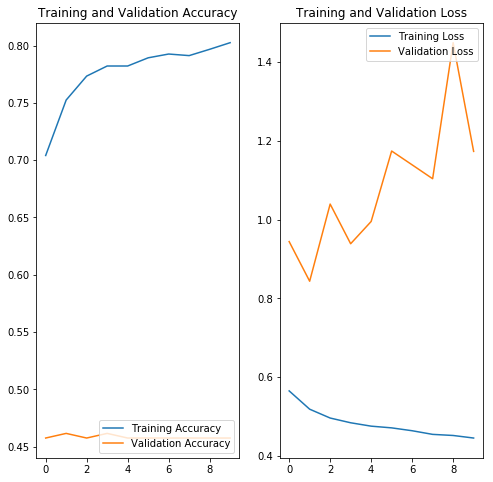

In [44]:
# Create a ROC curve
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()